In [1]:
# Fit Forward

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [64]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [65]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [104]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [134]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [121]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    for ii in range(1, 8):
        jj = ii + gap_length - 1
        if len(primary_river.iloc[spoint-8:spoint]) != 8:
            print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
        if ii > 1:
            b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
            linear[ii-2] = b + m * jj
        if ii > 2:
            b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
            cubic[ii-3] = b + m * jj + c * jj**2
    firstchoice = read_river(matching_dictionary[river], 'primary')
    for jj, length in enumerate(fitlength):
        for ii in range(length):
            denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
            if len(denom) == 1:
                ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                            firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
            else:
                bad = True
        if not bad:
            fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
    if bad:
        fittedbad = fittedbad + 1
    if doplots:
        ax.plot(persist)
        ax.plot(range(1, 7), linear)
        ax.plot(range(2, 7), cubic)
        if not bad:
            ax.plot(fitted)
        ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
        ax.plot(7, primary_river.iloc[spoint].values, 'x')
        ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
        ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad)

In [6]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [7]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [52]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [24]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, doplots=True):

    point = random.randrange(len(primary_river.index))
    gap_length = 1
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, doplots)

    GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
    accumulateG += GG
    accumulateC += CC
    accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad

In [96]:
river = 'Englishman'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  905.  905.  905.  905.] [ 4.67206974  5.36055141  5.69429184  6.08171645  6.60307008  6.98335677
  7.36976175  6.87103782  7.33603888  7.36047874  7.08022007  7.25472767
  7.41347752 12.17757455 10.69364499 10.69178037  9.88027171  9.75178474
  3.73513773  4.7085683   4.94764758  5.07731274] [0.054      0.08       0.094      0.122      0.142      0.163
 0.171      0.102      0.118      0.129      0.159      0.17
 0.183      0.159      0.158      0.178      0.174      0.185
 0.03646409 0.06850829 0.07845304 0.0961326 ] [0.    0.    0.    0.    0.    0.    0.    0.007 0.016 0.019 0.03  0.032
 0.027 0.04  0.05  0.047 0.052 0.061 0.    0.    0.    0.   ]


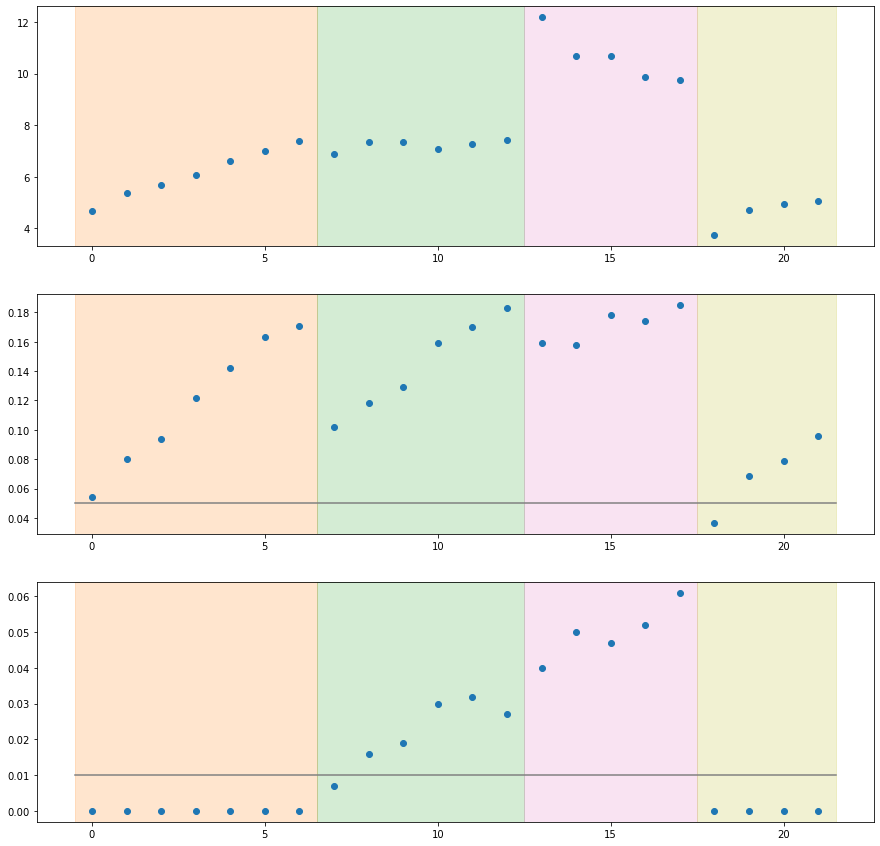

In [97]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [56]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  955.  955.  955.  955.] [29.88120962 37.81083291 44.37656246 49.22655085 52.35696641 55.01664245
 56.740392   34.78654288 39.45292935 44.85189469 47.11074792 50.88233959
 52.93933359 53.51703785 50.47749895 55.0011403  58.04941923 58.63288477
 33.0065343  40.12769128 44.30784444 48.58279714] [0.006      0.011      0.014      0.021      0.025      0.026
 0.03       0.01       0.02       0.023      0.022      0.029
 0.031      0.051      0.044      0.053      0.052      0.061
 0.0104712  0.01884817 0.02198953 0.02303665] [0.         0.         0.         0.         0.         0.
 0.         0.001      0.003      0.004      0.003      0.006
 0.006      0.015      0.011      0.012      0.013      0.016
 0.00104712 0.00104712 0.00314136 0.00314136]


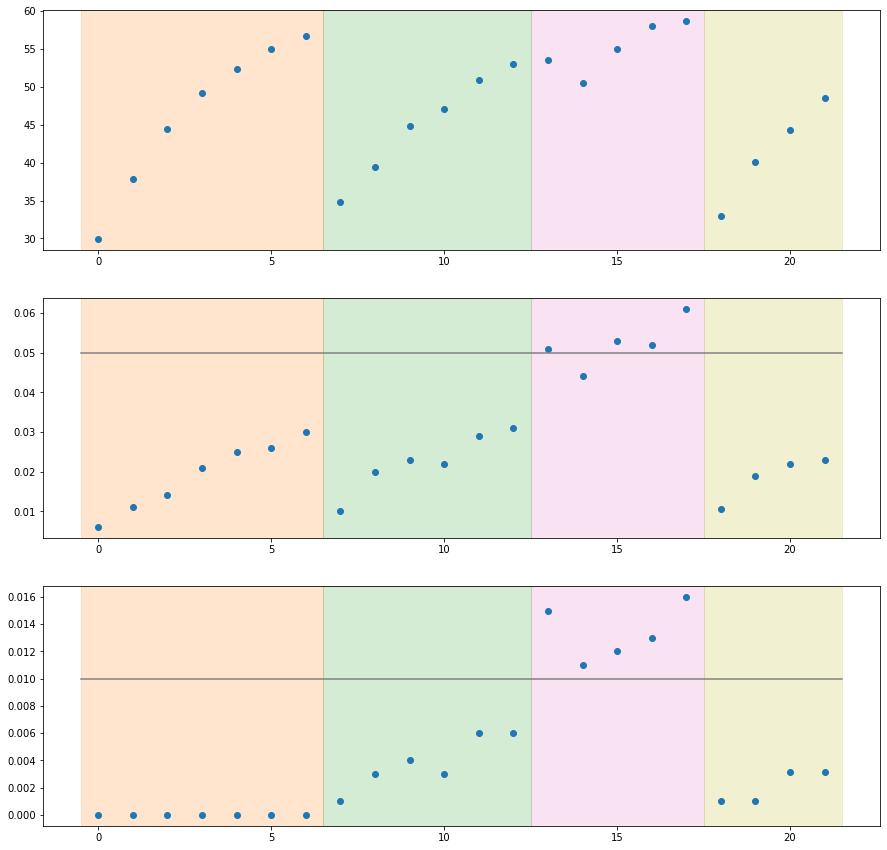

In [57]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [58]:
river = 'Salmon_Sayward'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  655.  655.  655.  655.] [18.91387594 21.42755989 23.49514624 25.57694146 27.00581658 27.43015499
 28.09929492 26.20472359 27.08661295 28.16608018 28.6342853  29.1889925
 29.79610978 41.23206926 39.15214705 39.08815318 38.92665831 37.98029592
 19.52482324 25.5179349  27.48433821 28.60991277] [0.054      0.074      0.09       0.109      0.13       0.131
 0.148      0.103      0.119      0.145      0.138      0.151
 0.165      0.174      0.179      0.191      0.205      0.209
 0.04885496 0.07022901 0.10992366 0.1221374 ] [0.    0.    0.    0.    0.    0.    0.    0.01  0.015 0.025 0.03  0.027
 0.024 0.05  0.054 0.051 0.057 0.061 0.    0.    0.    0.   ]


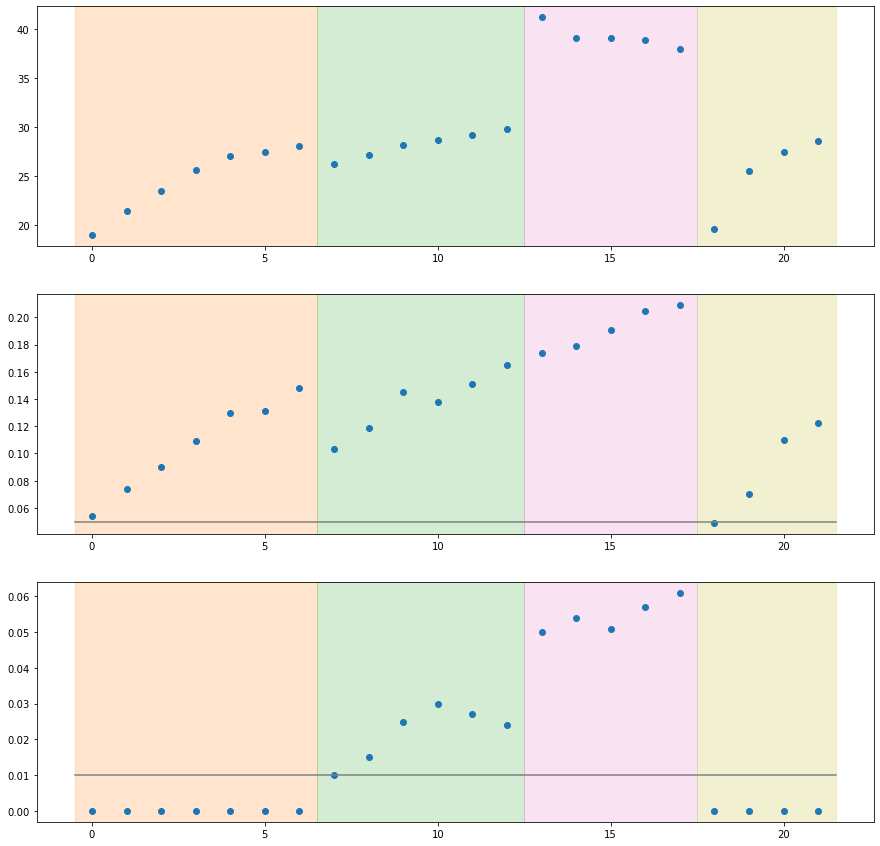

In [59]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [129]:
river = 'RobertsCreek'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  690.  690.  690.  690.] [0.44189208 0.48032931 0.50698151 0.53363444 0.56431162 0.59320367
 0.61202723 0.7551373  0.64695573 0.64703969 0.64393575 0.66587465
 0.6408058  1.37886454 0.98062133 0.92537821 0.90574267 0.87043054
 0.27961369 0.34507787 0.36756971 0.39809815] [0.093      0.12       0.149      0.161      0.186      0.195
 0.214      0.178      0.22       0.247      0.239      0.263
 0.264      0.291      0.265      0.299      0.321      0.33
 0.05507246 0.09565217 0.12173913 0.13913043] [0.    0.    0.    0.    0.    0.    0.    0.038 0.033 0.043 0.048 0.059
 0.059 0.093 0.08  0.093 0.097 0.106 0.    0.    0.    0.   ]


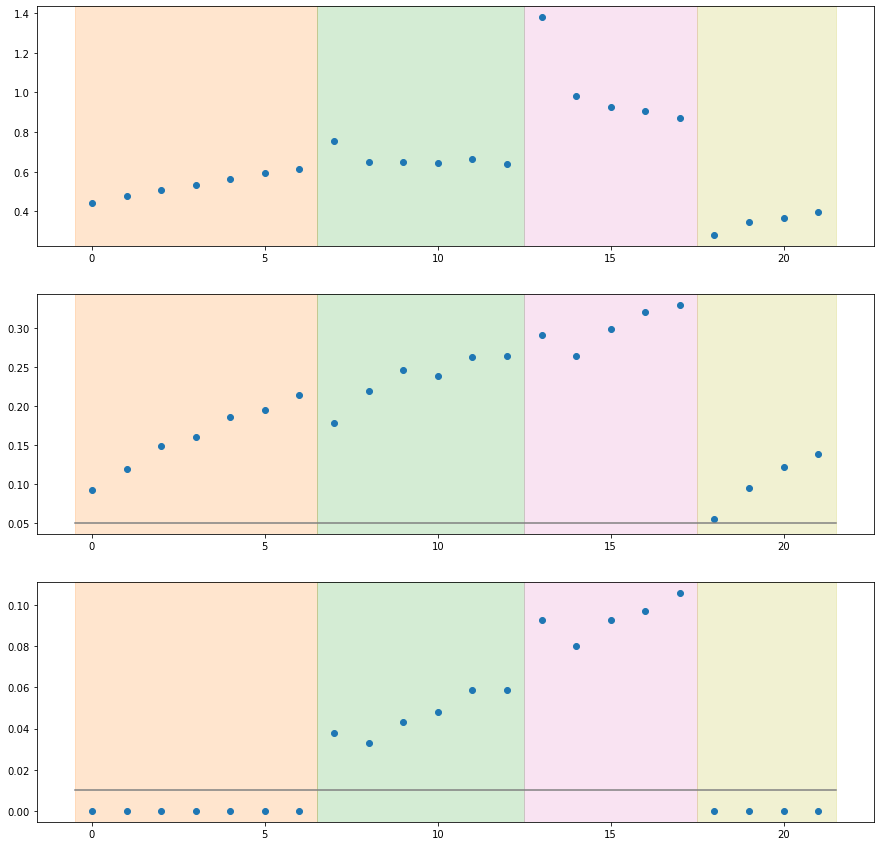

In [130]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [68]:
river = 'Squamish_Brackendale'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  866.  866.  866.  866.] [44.33415955 51.11453472 56.4626203  60.5976767  63.92567058 66.12540382
 68.02709924 56.83302434 60.1836626  61.32150594 63.05481695 66.18586587
 69.43297645 84.72045727 82.59917978 80.56045072 80.42313176 79.58955992
 32.28601909 40.98256031 46.251948   51.81148038] [0.023      0.03       0.034      0.047      0.055      0.062
 0.073      0.047      0.058      0.062      0.064      0.078
 0.09       0.116      0.106      0.111      0.123      0.122
 0.00577367 0.01154734 0.01732102 0.02193995] [0.    0.    0.    0.    0.    0.    0.    0.005 0.003 0.004 0.006 0.009
 0.009 0.028 0.03  0.033 0.032 0.029 0.    0.    0.    0.   ]


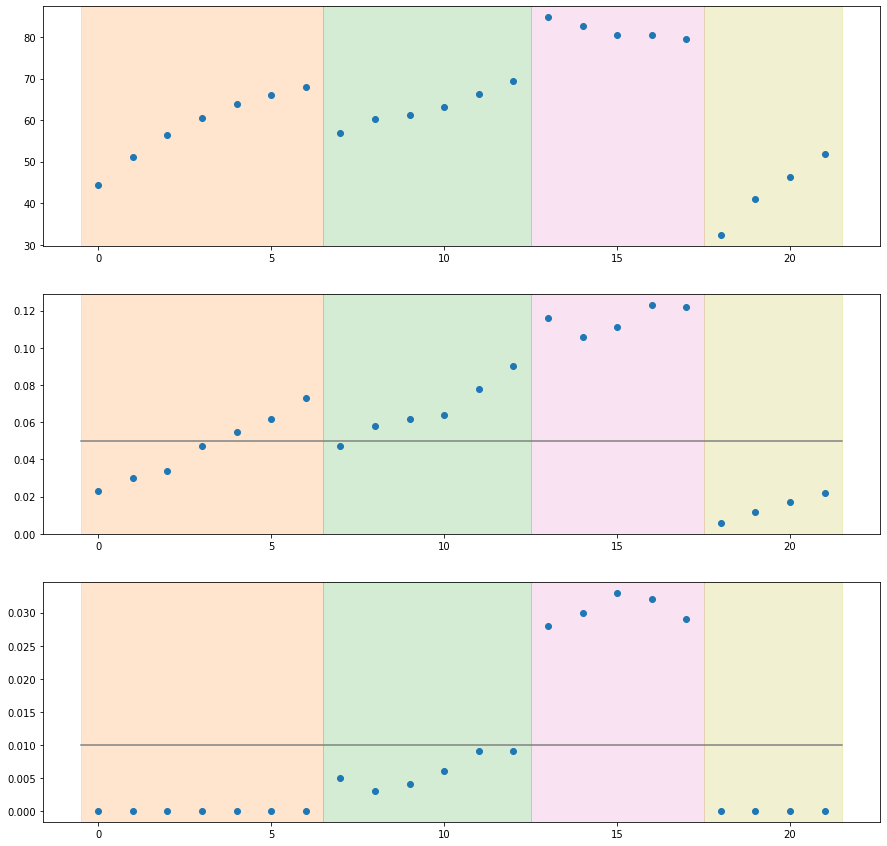

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [72]:
river = 'SanJuan_PortRenfrew'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  678.  678.  678.  678.] [23.14309322 27.57354458 28.60827898 29.66548933 31.32427385 32.51364545
 33.45865915 28.82501831 31.70611448 34.65107623 35.18747744 35.13661028
 36.3608833  46.11039028 40.86692596 42.57023532 44.9701909  45.21132735
 14.03251382 17.18887627 18.46759376 19.30019087] [0.087      0.118      0.154      0.186      0.206      0.224
 0.241      0.148      0.182      0.209      0.229      0.248
 0.259      0.216      0.229      0.244      0.278      0.287
 0.03982301 0.05899705 0.08849558 0.09144543] [0.         0.         0.         0.         0.         0.
 0.         0.022      0.026      0.041      0.044      0.053
 0.054      0.072      0.071      0.073      0.088      0.1
 0.00442478 0.00294985 0.00442478 0.00737463]


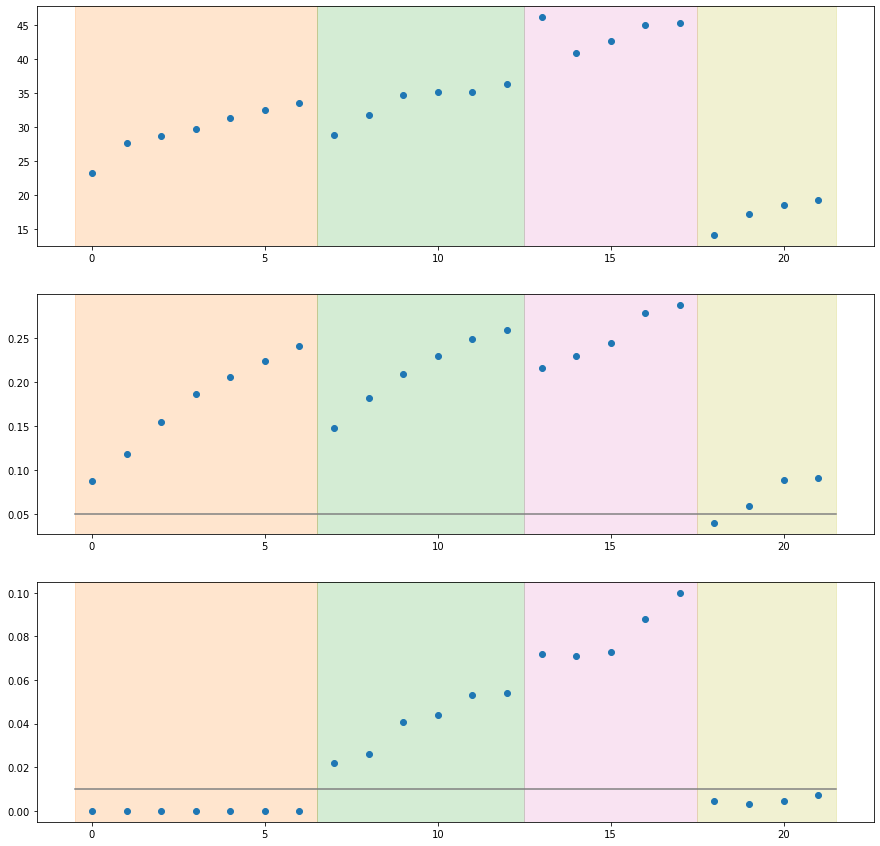

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [132]:
river = 'SanJuan_PortRenfrew'
# use backup River
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  987.  987.  987.  987.] [24.95935643 26.98511153 28.62311418 30.04023596 30.89772771 32.09081357
 33.11956986 33.08561189 32.26793401 33.52170019 34.69055196 35.29086098
 36.79723736 54.1972216  46.91685536 43.92680484 42.20854302 40.85976965
 19.55875219 21.3966502  23.43737358 26.03236566] [0.104      0.139      0.165      0.185      0.212      0.221
 0.249      0.167      0.193      0.208      0.233      0.27
 0.285      0.235      0.227      0.248      0.26       0.278
 0.07598784 0.10840932 0.12056738 0.13069909] [0.         0.         0.         0.         0.         0.
 0.         0.022      0.029      0.034      0.039      0.047
 0.059      0.08       0.078      0.084      0.075      0.083
 0.00202634 0.00202634 0.00101317 0.00303951]


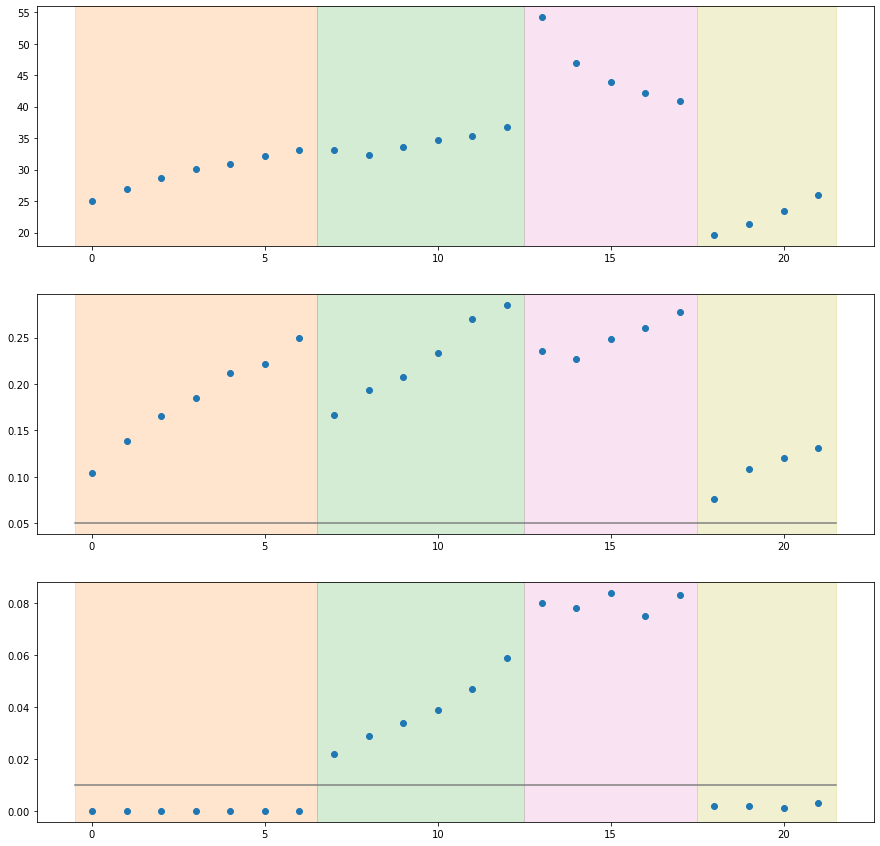

In [133]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [137]:
river = 'Nicomekl_Langley'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  987.  987.  987.  987.] [1.10070308 1.23271728 1.27213884 1.29265257 1.29391143 1.32961456
 1.36872957 1.77914594 1.67265735 1.5789042  1.53621067 1.58193599
 1.5700609  3.2768442  2.54459206 2.27400397 2.12657819 1.99673408
 0.89339187 1.05957688 1.07683769 1.11482524] [0.141      0.173      0.223      0.238      0.255      0.267
 0.271      0.284      0.284      0.288      0.298      0.301
 0.335      0.367      0.347      0.367      0.389      0.374
 0.10435664 0.15906788 0.19250253 0.20668693] [0.         0.         0.         0.         0.         0.
 0.         0.073      0.072      0.07       0.057      0.061
 0.076      0.137      0.143      0.143      0.145      0.137
 0.         0.00101317 0.         0.        ]


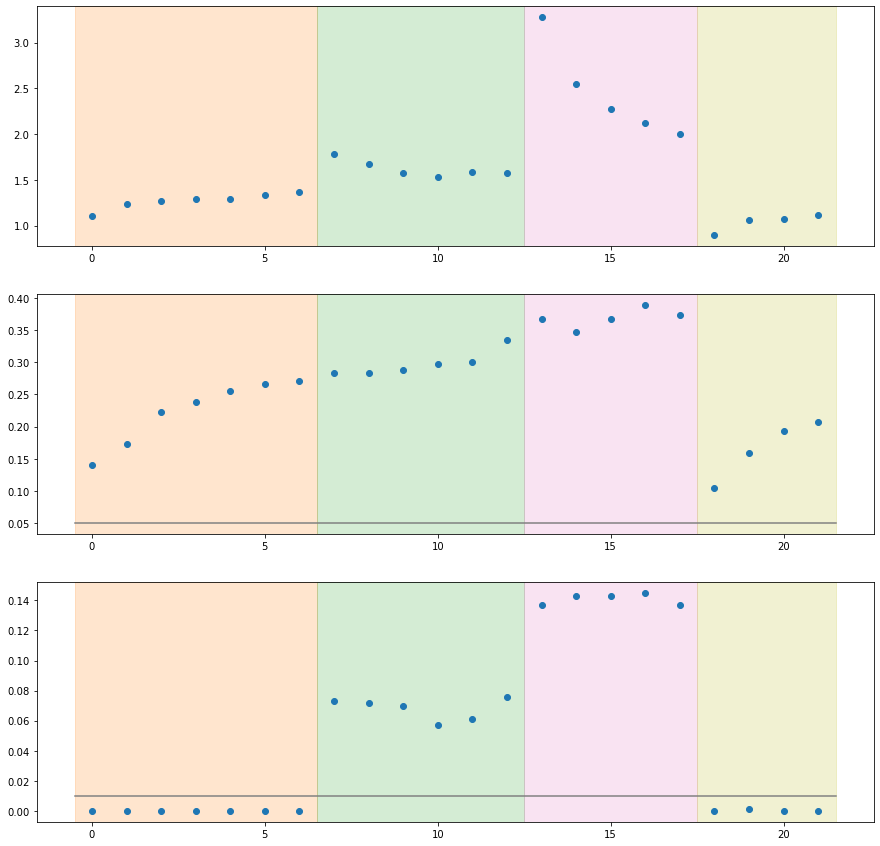

In [138]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [82]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  999.  999.  999.  999.] [47.8186356  59.73723365 67.38552767 72.78710265 76.73858316 80.1763707
 83.37599661 48.60843902 62.51252313 70.24222772 75.01920375 78.62293548
 82.29856648 70.76435483 74.70108402 86.10301499 91.42893888 92.46426436
 37.84836334 49.04758607 54.24645336 58.61829659] [0.017      0.03       0.035      0.05       0.054      0.064
 0.068      0.022      0.036      0.055      0.069      0.069
 0.073      0.073      0.075      0.084      0.102      0.102
 0.00700701 0.01501502 0.02102102 0.03003003] [0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.006 0.009 0.005
 0.007 0.012 0.019 0.028 0.033 0.035 0.    0.    0.    0.   ]


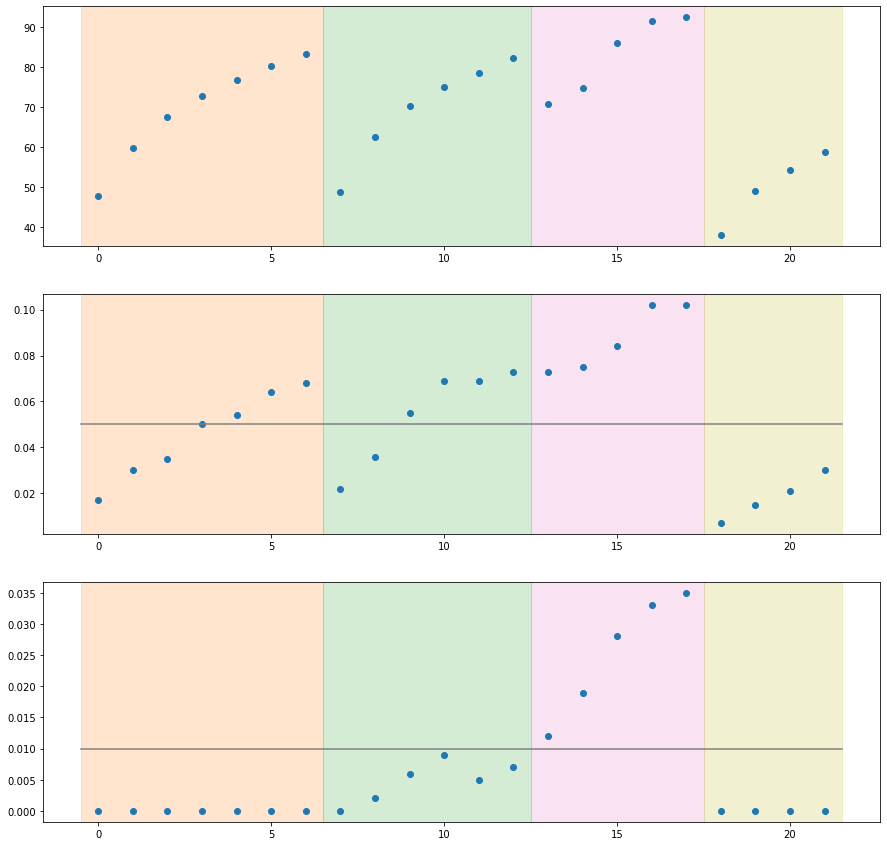

In [83]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [84]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  997.  997.  997.  997.] [ 60.0049977   71.5789258   79.5247137   87.6988303   93.75171372
  98.40257977 102.54949349  69.5539843   78.8713471   86.5231201
  89.32438532  92.90625281  96.68747306 112.3231129   98.09731435
 102.73458788 107.5576206  113.08593569  81.81936345 111.29892665
 124.46565845 136.05635776] [0.011      0.017      0.017      0.022      0.023      0.028
 0.031      0.014      0.015      0.023      0.021      0.03
 0.028      0.049      0.04       0.039      0.048      0.052
 0.0110331  0.02507523 0.03209629 0.03811434] [0.         0.         0.         0.         0.         0.
 0.         0.006      0.002      0.002      0.004      0.003
 0.004      0.024      0.014      0.017      0.015      0.016
 0.00200602 0.00200602 0.00200602 0.00200602]


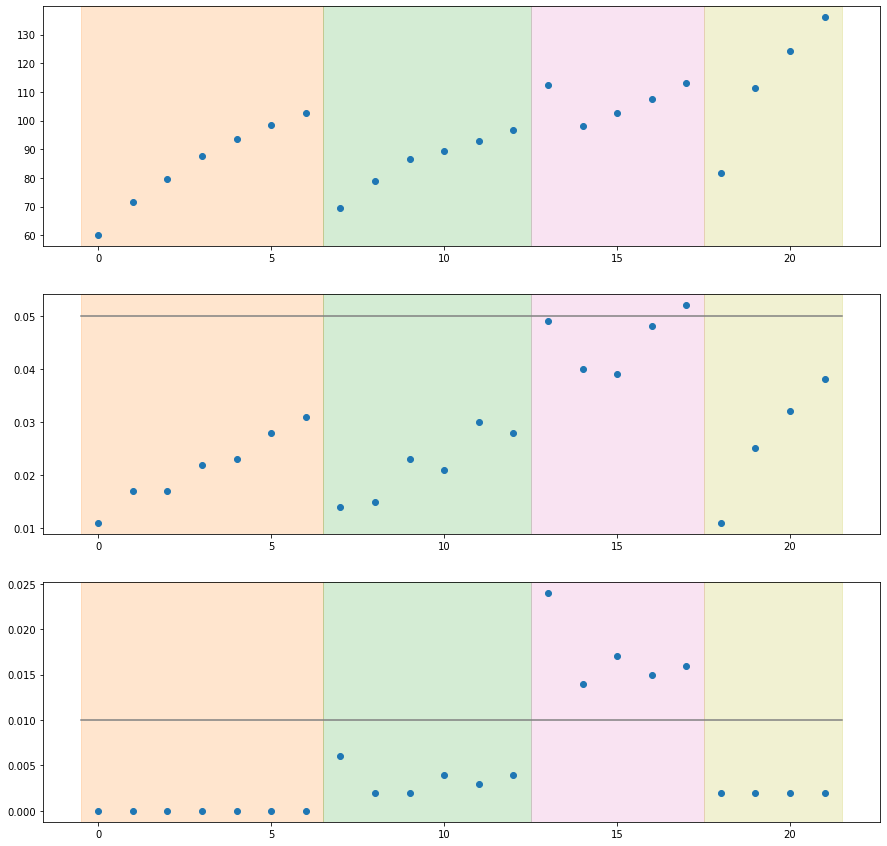

In [85]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [86]:
river = 'Nisqually_McKenna'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  999.  999.  999.  999.] [ 4.37681435  5.63219724  6.5339127   7.45225263  8.23869941  8.77796741
  9.16820719  5.28507476  5.6550249   6.10818877  6.58430163  7.12107488
  7.58655623  8.13365927  7.57255516  8.06792555  8.12881538  8.31817714
  8.47637904 11.87076591 13.46898597 14.64669402] [0.009      0.014      0.019      0.027      0.037      0.04
 0.045      0.015      0.015      0.018      0.027      0.032
 0.031      0.047      0.039      0.041      0.037      0.03
 0.03003003 0.06906907 0.08308308 0.11011011] [0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.001 0.002 0.002
 0.001 0.012 0.009 0.005 0.007 0.012 0.    0.    0.    0.   ]


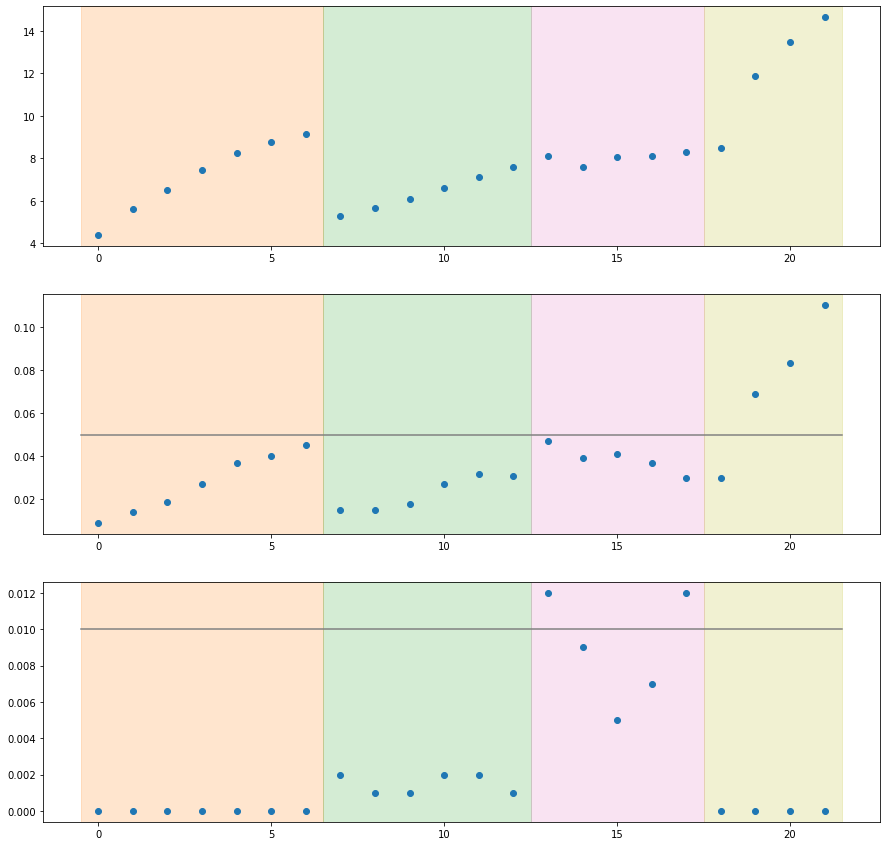

In [87]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [90]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  996.  996.  996.  996.] [0.82195723 1.08982712 1.2338431  1.29126934 1.33348276 1.41966782
 1.51861288 0.83777807 1.07153129 1.16505928 1.33482013 1.45694996
 1.51397172 1.38928747 1.44040836 1.52117736 1.46338649 1.40045023
 0.85473877 1.07450716 1.21728844 1.31622915] [0.016      0.021      0.025      0.029      0.03       0.029
 0.031      0.02       0.023      0.024      0.034      0.035
 0.035      0.039      0.038      0.052      0.051      0.041
 0.01807229 0.02409639 0.02710843 0.03413655] [0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.001 0.    0.002
 0.003 0.01  0.013 0.017 0.011 0.012 0.    0.    0.    0.   ]


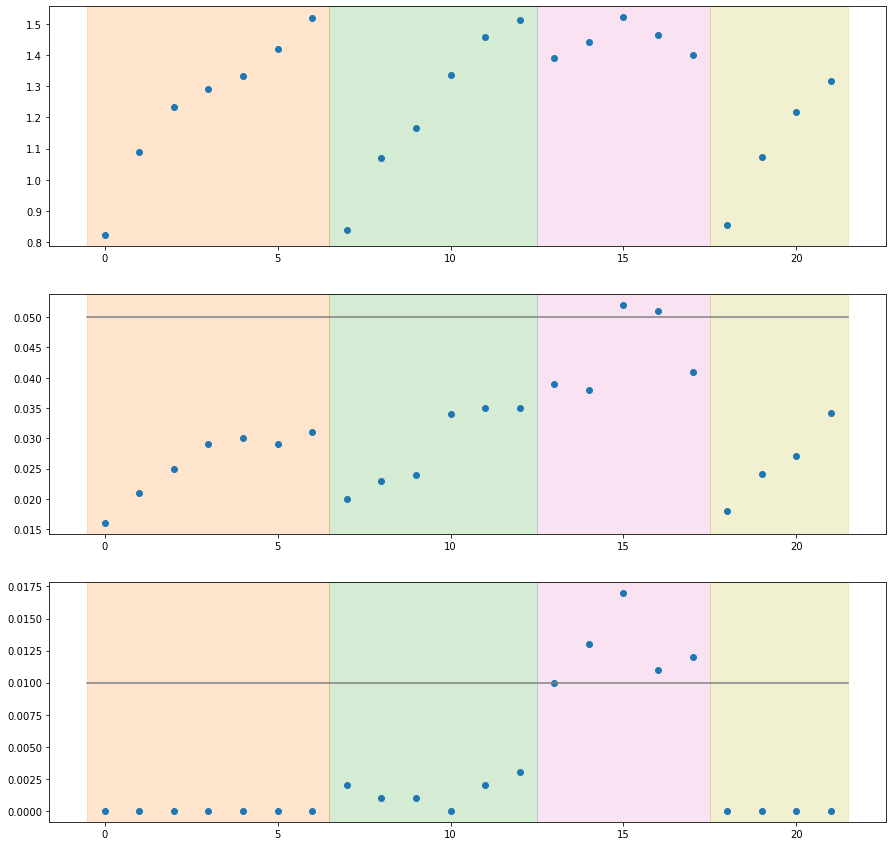

In [91]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [94]:
river = 'Clowhom_ClowhomLake'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  765.  765.  765.  765.] [4.20055513 4.9766252  5.3544638  5.49865614 5.67227748 6.00606229
 6.28927942 5.64001031 5.92574193 6.21680559 6.51257882 6.7850782
 6.77004382 8.9008688  8.14659983 7.92301354 8.2666938  8.24495173
 5.16142179 7.14535287 7.72415158 8.47179196] [0.052      0.075      0.087      0.1        0.112      0.13
 0.14       0.099      0.114      0.131      0.15       0.173
 0.186      0.178      0.164      0.167      0.188      0.202
 0.05359477 0.07320261 0.09411765 0.11372549] [0.         0.         0.         0.         0.         0.
 0.         0.013      0.016      0.019      0.027      0.031
 0.034      0.068      0.049      0.045      0.057      0.065
 0.00130719 0.00522876 0.00392157 0.00653595]


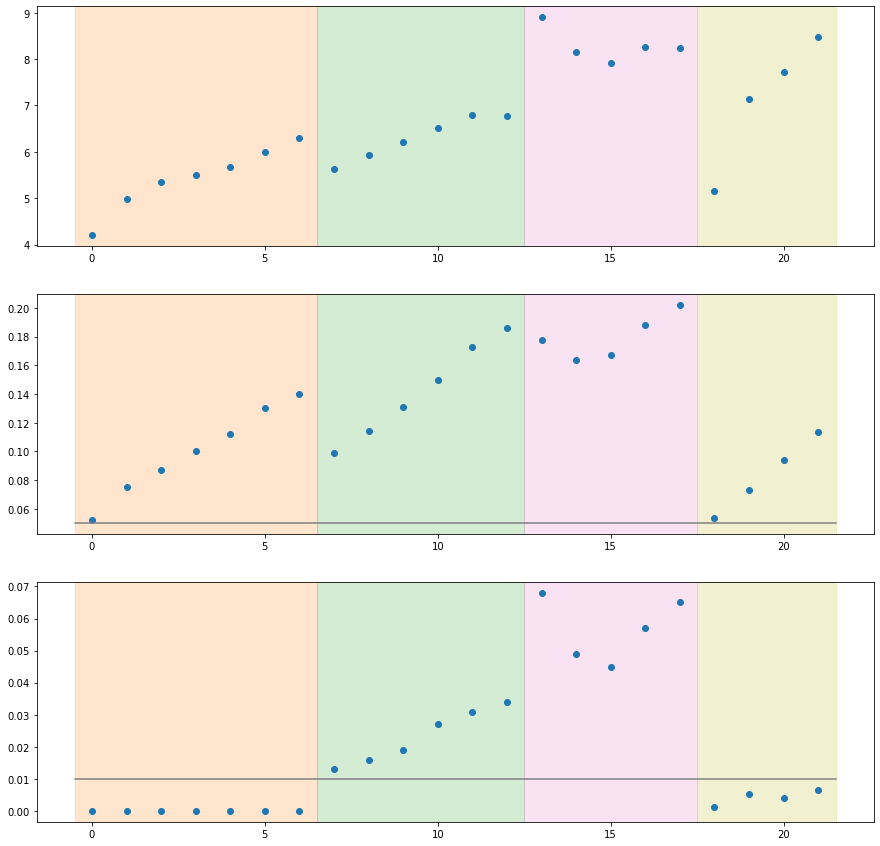

In [95]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [122]:
river = 'Theodosia'

primary_river = read_river_Theodosia(set_primary=True)
primary_river = primary_river.drop(['Diversion_x', 'Bypass', 'Scotty', 'Diversion_y', 
                                   'FlowFromDiversion'], axis=1)

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
0 Primary River Flow    6.23044
Name: 2000-04-16 00:00:00, dtype: float64
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  970.  970.  970.  970.] [3.70017798 4.32454319 4.64281777 4.8643303  4.95949154 5.03872565
 5.06773329 5.71935296 5.63747641 5.3722075  5.73865512 5.77646353
 5.76863731 9.84364429 8.56530127 7.77331034 7.31870922 7.06848867
 3.26733008 4.04333703 4.80261918 5.49611154] [0.107      0.146      0.187      0.204      0.223      0.222
 0.247      0.212      0.219      0.25

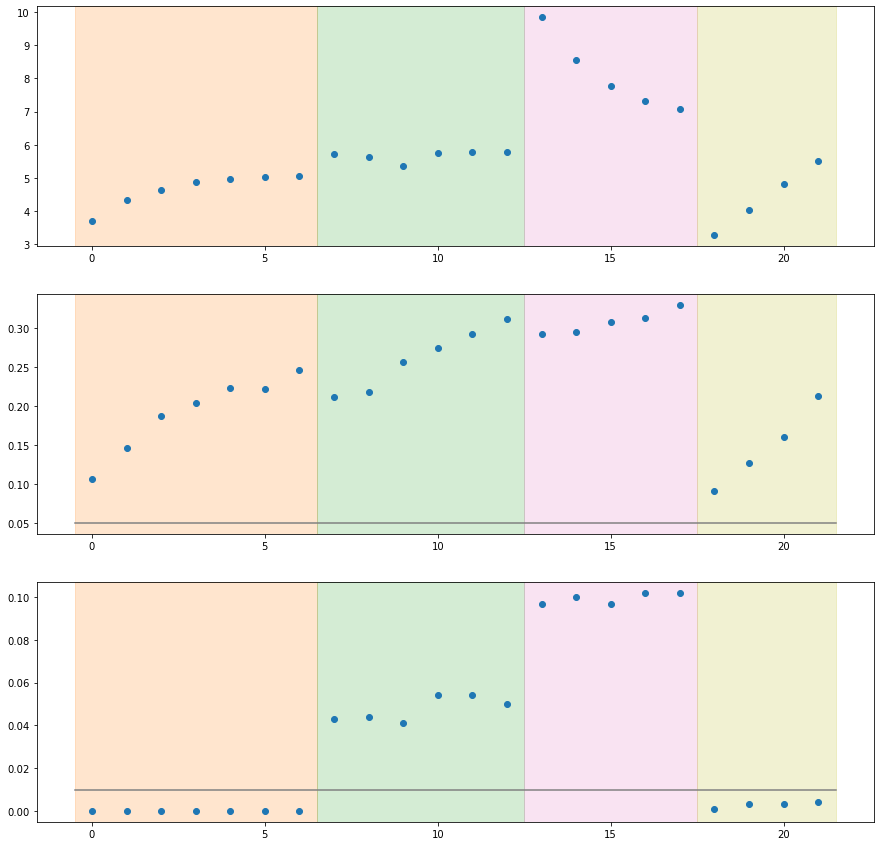

In [123]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [126]:
river = 'Theodosia'

# Try Clowhom Lake

primary_river = read_river_Theodosia(set_primary=True)
primary_river = primary_river.drop(['Diversion_x', 'Bypass', 'Scotty', 'Diversion_y', 
                                   'FlowFromDiversion'], axis=1)

number_trys = 1000
fittedbad = 0
gap_length = 1
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, 1,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [3.98287972 4.64588726 4.76989382 4.7600159  4.81448195 4.88958129
 4.97237261 5.69548524 5.53357812 5.84531654 6.08288265 6.1298184
 6.05959363 9.78171578 7.79563656 7.19236749 7.25653603 7.44575715
 2.5357053  2.87596672 3.01561903 3.21071125] [0.116 0.158 0.173 0.201 0.221 0.23  0.243 0.203 0.242 0.261 0.289 0.309
 0.318 0.276 0.294 0.326 0.318 0.348 0.038 0.069 0.081 0.104] [0.    0.    0.    0.    0.    0.    0.    0.037 0.03  0.038 0.044 0.049
 0.051 0.098 0.103 0.097 0.091 0.108 0.002 0.    0.    0.   ]


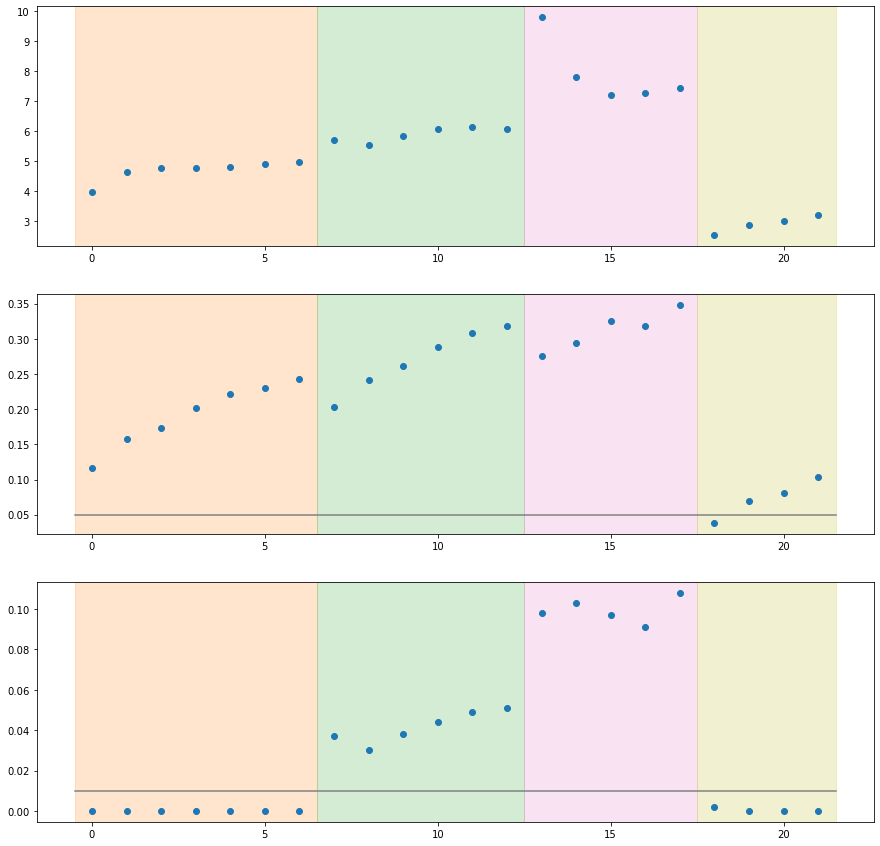

In [127]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');